In [ ]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 996.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import requests
from PIL import Image
import io
import kagglehub
import os
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 1. Демонстрация операции Upsampling на тестовом изображении

 Пример пространственного расширения изображения с использованием двух методов: билинейной интерполяции и транспонированной свёртки

In [ ]:
def bilinear_upsampling(image, scale_factor):
    # Получаем размеры изображения
    height, width = image.shape[:2]

    # Новые размеры после масштабирования
    new_height = int(height * scale_factor)
    new_width = int(width * scale_factor)

    # Создаем пустое изображение нового размера
    upscaled_image = np.zeros((new_height, new_width, 3), dtype=np.uint8)

    for y in range(new_height):
        for x in range(new_width):
            # Вычисляем координаты в оригинальном изображении
            src_y = y / scale_factor
            src_x = x / scale_factor

            # Билинейная интерполяция
            y_floor = int(np.floor(src_y))
            y_ceil = min(y_floor + 1, height - 1)
            x_floor = int(np.floor(src_x))
            x_ceil = min(x_floor + 1, width - 1)

            # Получаем значения пикселей вокруг точки
            q11 = image[y_floor, x_floor]
            q12 = image[y_floor, x_ceil]
            q21 = image[y_ceil, x_floor]
            q22 = image[y_ceil, x_ceil]

            # Расчёт весов
            dx = src_x - x_floor
            dy = src_y - y_floor

            # Билинейная интерполяция
            r = (1 - dx) * (1 - dy) * q11[0] + dx * (1 - dy) * q12[0] + (1 - dx) * dy * q21[0] + dx * dy * q22[0]
            g = (1 - dx) * (1 - dy) * q11[1] + dx * (1 - dy) * q12[1] + (1 - dx) * dy * q21[1] + dx * dy * q22[1]
            b = (1 - dx) * (1 - dy) * q11[2] + dx * (1 - dy) * q12[2] + (1 - dx) * dy * q21[2] + dx * dy * q22[2]

            upscaled_image[y, x] = [int(r), int(g), int(b)]

    return upscaled_image

In [ ]:
class TransposedConvUpsampling(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(TransposedConvUpsampling, self).__init__()

        # Первый блок: увеличение разрешения
        self.conv1 = nn.ConvTranspose2d(in_channels, 64, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        # Второй блок: дальнейшее увеличение разрешения
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()

        # Выходной блок: получение выходных каналов
        self.conv_out = nn.ConvTranspose2d(32, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.conv_out(x)
        return x

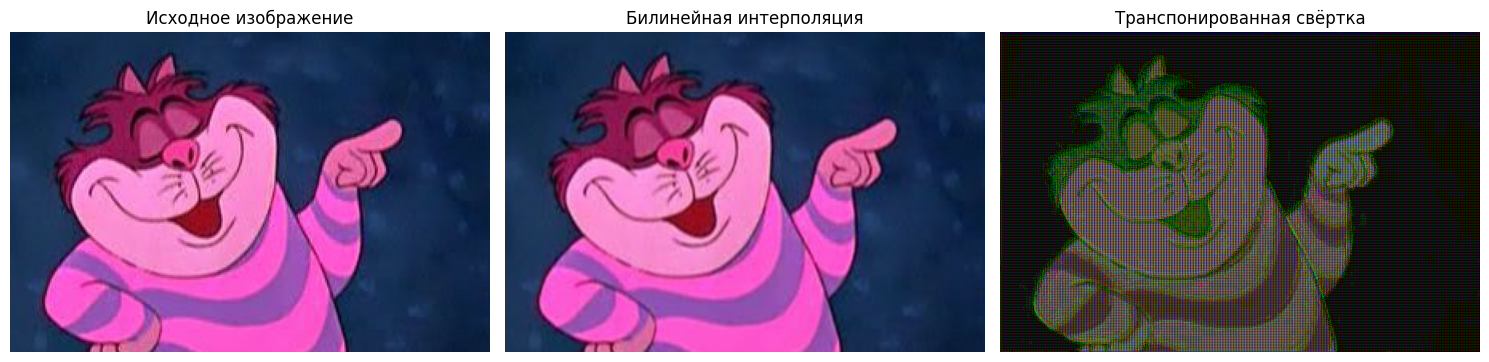

In [ ]:
image_url = 'https://i.pinimg.com/736x/ac/86/d5/ac86d50362084ff1100bbb13736f331a.jpg'

try:
   # Загрузка изображения
  response = requests.get(image_url)
  image = Image.open(io.BytesIO(response.content))

  # Конвертация в формат OpenCV (BGR)
  # BGR -> RGB
  image = np.array(image)[:, :, ::-1]
except:
    print("Ошибка: Не удалось загрузить изображение")
    exit()

# Параметры вырезания
x_start = 250   # Начальная позиция X
y_start = 150   # Начальная позиция Y
width = 300     # Ширина вырезаемого куска
height = 200    # Высота вырезаемого куска

# Вырезаем область изображения
cropped_image = image[y_start:y_start + height, x_start:x_start + width]

# Масштабирование
scale_factor = 2.5
# Билинейная интерполяция
bilinear_result = bilinear_upsampling(cropped_image, scale_factor)

# Транспонированная свёртка
# Преобразуем изображение в тензор PyTorch
image_tensor = torch.tensor(cropped_image.copy()).permute(2, 0, 1).float().unsqueeze(0)  # (1, C, H, W)

# Создаем модель
model = TransposedConvUpsampling(in_channels=3, out_channels=3)
with torch.no_grad():
    transposed_result = model(image_tensor).squeeze(0).permute(1, 2, 0).numpy().astype(np.uint8)

# Визуализация
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(bilinear_result, cv2.COLOR_BGR2RGB))
plt.title('Билинейная интерполяция')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(transposed_result, cv2.COLOR_BGR2RGB))
plt.title('Транспонированная свёртка')
plt.axis('off')

plt.tight_layout()
plt.show()

Что было сделано:
1. Подготовка данных и загрузка изображения.
* Из исходного изображения была вырезана область размером 300x200 пикселей, начиная с координат (x=250, y=150). Это было сделано для упрощения анализа и фокуса на конкретной части изображения.
* Изображение было преобразовано из формата RGB в BGR, так как OpenCV использует этот формат по умолчанию.
2. Пространственное расширение с помощью билинейной интерполяции.
Билинейная интерполяция — это техника, которая использует четыре ближайших пикселя к точке, где нужно определить значение, и вычисляет новое значение путём взвешенного среднего этих четырёх пикселей.
* Для каждого пикселя нового изображения были рассчитаны его координаты в исходном изображении.
* Ближайшие четыре пикселя в исходном изображении были использованы для вычисления значения нового пикселя с использованием формулы билинейной интерполяции.
* В результате овое изображение было создано с увеличенным разрешением в 2.5 раза. Качество масштабирования было хорошим, сохранялись детали и гладкость переходов между пикселями.
3. Пространственное расширение с помощью транспонированной свёртки.
Транспонированная свёртка (ConvTranspose2d) — это операция, обратная обычной свёртке. Она используется для увеличения размера изображения и часто применяется в нейронных сетях для задач восстановления изображений.
* Архитектура модели :
  * Первый блок : Слои ConvTranspose2d, BatchNorm2d и ReLU увеличивают разрешение изображения в два раза.
  * Второй блок : Дополнительное увеличение разрешения ещё в два раза.
  *Выходной слой : Конечный слой ConvTranspose2d для получения выходного изображения с требуемым числом каналов (RGB).
* Входное изображение было преобразовано в тензор PyTorch с размерностью (1, C, H, W), где C — число каналов (3 для RGB), H и W — высота и ширина изображения.
Модель была применена к входному тензору без вычисления градиентов (with torch.no_grad()).Результат был преобразован обратно в NumPy массив для дальнейшего анализа.
* В результате новое изображение также было создано с увеличенным разрешением в 2.5 раза. Однако качество масштабирования оказалось значительно хуже, чем при использовании билинейной интерполяции. На изображении появились артефакты, такие как чёткие границы и неестественные цветовые переходы.
* В данном случае модель не была обучена, поэтому результаты оказались плохими.
Без обучения транспонированная свёртка может приводить к появлению артефактов и искажений.

### Итог:
Для простого масштабирования изображения с целью сохранения качества рекомендуется использовать билинейную интерполяцию.Транспонированная свёртка может быть эффективна в контексте нейронных сетей, но требует предварительного обучения для получения хороших результатов. В данном случае её использование без обучения привело к значительному снижению качества изображения.

#2. Модель сегментации
Возьмём модель U-Net и набор данных CamVid.

In [ ]:
path = kagglehub.dataset_download('carlolepelaars/camvid')

print('Путь до данных:', path)

100%|██████████| 575M/575M [00:05<00:00, 108MB/s]

Extracting files...


Путь до данных: /root/.cache/kagglehub/datasets/carlolepelaars/camvid/versions/2


In [ ]:
# Пути к данным
IMAGE_DIR = f'{path}/CamVid/train'
MASK_DIR = f'{path}/CamVid/train_labels'
VAL_IMAGE_DIR = f'{path}/CamVid/val'
VAL_MASK_DIR = f'{path}/CamVid/val_labels'
TEST_IMAGE_DIR = f'{path}/CamVid/test'
TEST_MASK_DIR = f'{path}/CamVid/test_labels'
CLASS_DICT_PATH = f'{path}/CamVid/class_dict.csv'

In [ ]:
# Загрузка классов из class_dict.csv
color_map_df = pd.read_csv(CLASS_DICT_PATH)

# Создание словаря для преобразования RGB -> метка класса
color_to_class = {}
for idx, row in color_map_df.iterrows():
    rgb = (row['r'], row['g'], row['b'])
    color_to_class[rgb] = idx

# Функция для преобразования RGB-маски в одноканальную
def rgb_to_class_mask(mask, color_to_class):
    h, w, _ = mask.shape
    class_mask = np.zeros((h, w), dtype=np.uint8)
    for y in range(h):
        for x in range(w):
            rgb = tuple(mask[y, x])
            class_mask[y, x] = color_to_class.get(rgb, 0)  # 0 - фоновый класс
    return class_mask

In [ ]:
class CamVidDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, color_to_class=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.color_to_class = color_to_class
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))

        # Преобразование RGB-маски в одноканальную
        if self.color_to_class:
            mask = rgb_to_class_mask(mask, self.color_to_class)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Преобразование маски в torch.long
        mask = mask.clone().detach()
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

In [ ]:
# Аугментации
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Создание датасетов
train_dataset = CamVidDataset(IMAGE_DIR, MASK_DIR, transform=transform, color_to_class=color_to_class)
val_dataset = CamVidDataset(VAL_IMAGE_DIR, VAL_MASK_DIR, transform=transform, color_to_class=color_to_class)
test_dataset = CamVidDataset(TEST_IMAGE_DIR, TEST_MASK_DIR, transform=transform, color_to_class=color_to_class)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

<ipython-input-9-2c385c1c1044>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


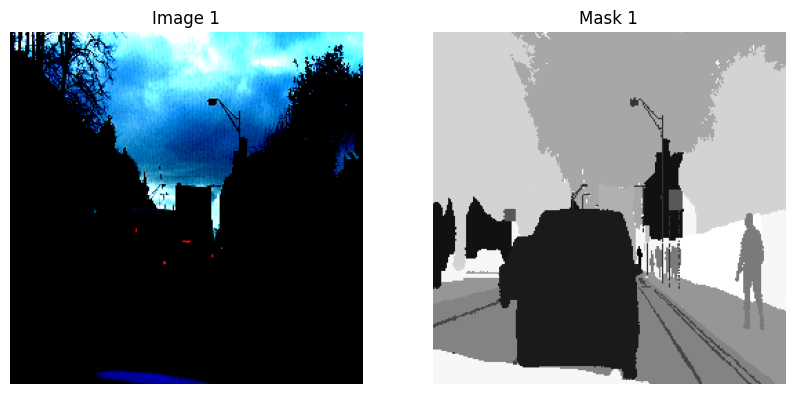

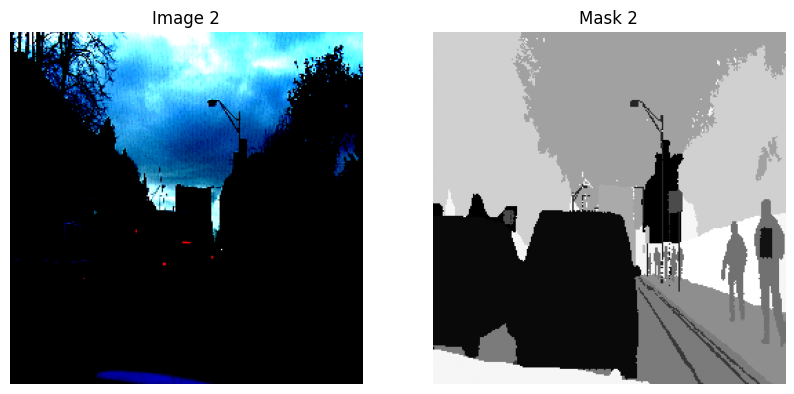

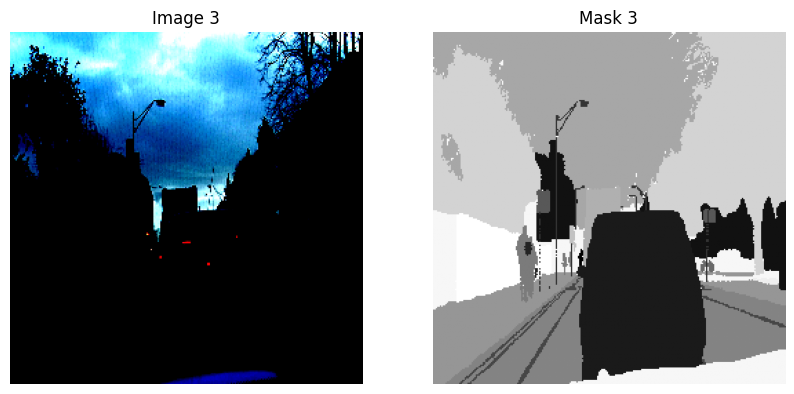

In [ ]:
# Визуализация датасета
def visualize_dataset(dataset, num_samples=5):
    for i in range(num_samples):
        image, mask = dataset[i]

        image_np = image.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.cpu().numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title(f'Image {i+1}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title(f'Mask {i+1}')
        plt.axis('off')
        plt.show()

visualize_dataset(train_dataset, num_samples=3)

In [ ]:
# Определение модели U-Net
model = smp.Unet(
    encoder_name='resnet34',  # Используем ResNet-34 как энкодер
    encoder_weights='imagenet',  # Инициализация весов предобученной модели
    in_channels=3,  # Количество входных каналов (RGB)
    classes=32,  # Количество классов для сегментации (CamVid имеет 32 класса)
    activation=None  # Без активации на выходе
)

# Перемещение модели на GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Функция потерь
criterion = nn.CrossEntropyLoss()

# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
# Метрики (IoU, Dice)
def calculate_iou(pred, target, num_classes=32):
    ious = []
    pred = torch.argmax(pred, dim=1)
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).float().sum()
        union = (pred_cls | target_cls).float().sum()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((intersection / union).item())
    return np.nanmean(ious)

def calculate_dice(pred, target, num_classes=32):
    dices = []
    pred = torch.argmax(pred, dim=1)
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).float().sum()
        dice = (2. * intersection) / (pred_cls.float().sum() + target_cls.float().sum())
        if dice == 0:
            dices.append(float('nan'))
        else:
            dices.append(dice.item())
    return np.nanmean(dices)

In [ ]:
# Тренировочный цикл
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_iou = 0
    train_dice = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += calculate_iou(outputs, masks)
        train_dice += calculate_dice(outputs, masks)

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)
    train_dice /= len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.3f}, IoU: {train_iou:.3f}, Dice: {train_dice:.3f}')

    # Валидация
    model.eval()
    val_loss = 0
    val_iou = 0
    val_dice = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_iou += calculate_iou(outputs, masks)
            val_dice += calculate_dice(outputs, masks)

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_dice /= len(val_loader)

    print(f'Validation Loss: {val_loss:.3f}, IoU: {val_iou:.3f}, Dice: {val_dice:.3f}')

<ipython-input-9-2c385c1c1044>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch [1/10], Loss: 2.738, IoU: 0.054, Dice: 0.137
Validation Loss: 2.242, IoU: 0.078, Dice: 0.236
Epoch [2/10], Loss: 2.046, IoU: 0.109, Dice: 0.321
Validation Loss: 1.772, IoU: 0.121, Dice: 0.417
Epoch [3/10], Loss: 1.624, IoU: 0.135, Dice: 0.462
Validation Loss: 1.458, IoU: 0.141, Dice: 0.534
Epoch [4/10], Loss: 1.346, IoU: 0.148, Dice: 0.564
Validation Loss: 1.207, IoU: 0.161, Dice: 0.613
Epoch [5/10], Loss: 1.146, IoU: 0.161, Dice: 0.598
Validation Loss: 1.066, IoU: 0.175, Dice: 0.627
Epoch [6/10], Loss: 1.011, IoU: 0.172, Dice: 0.618
Validation Loss: 0.950, IoU: 0.195, Dice: 0.662
Epoch [7/10], Loss: 0.907, IoU: 0.181, Dice: 0.624
Validation Loss: 0.892, IoU: 0.196, Dice: 0.626
Epoch [8/10], Loss: 0.827, IoU: 0.183, Dice: 0.632
Validation Loss: 0.814, IoU: 0.199, Dice: 0.627
Epoch [9/10], Loss: 0.769, IoU: 0.190, Dice: 0.649
Validation Loss: 0.778, IoU: 0.204, Dice: 0.647
Epoch [10/10], Loss: 0.721, IoU: 0.204, Dice: 0.688
Validation Loss: 0.739, IoU: 0.212, Dice: 0.661


<ipython-input-9-2c385c1c1044>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Test IoU: 0.212, Test Dice: 0.666


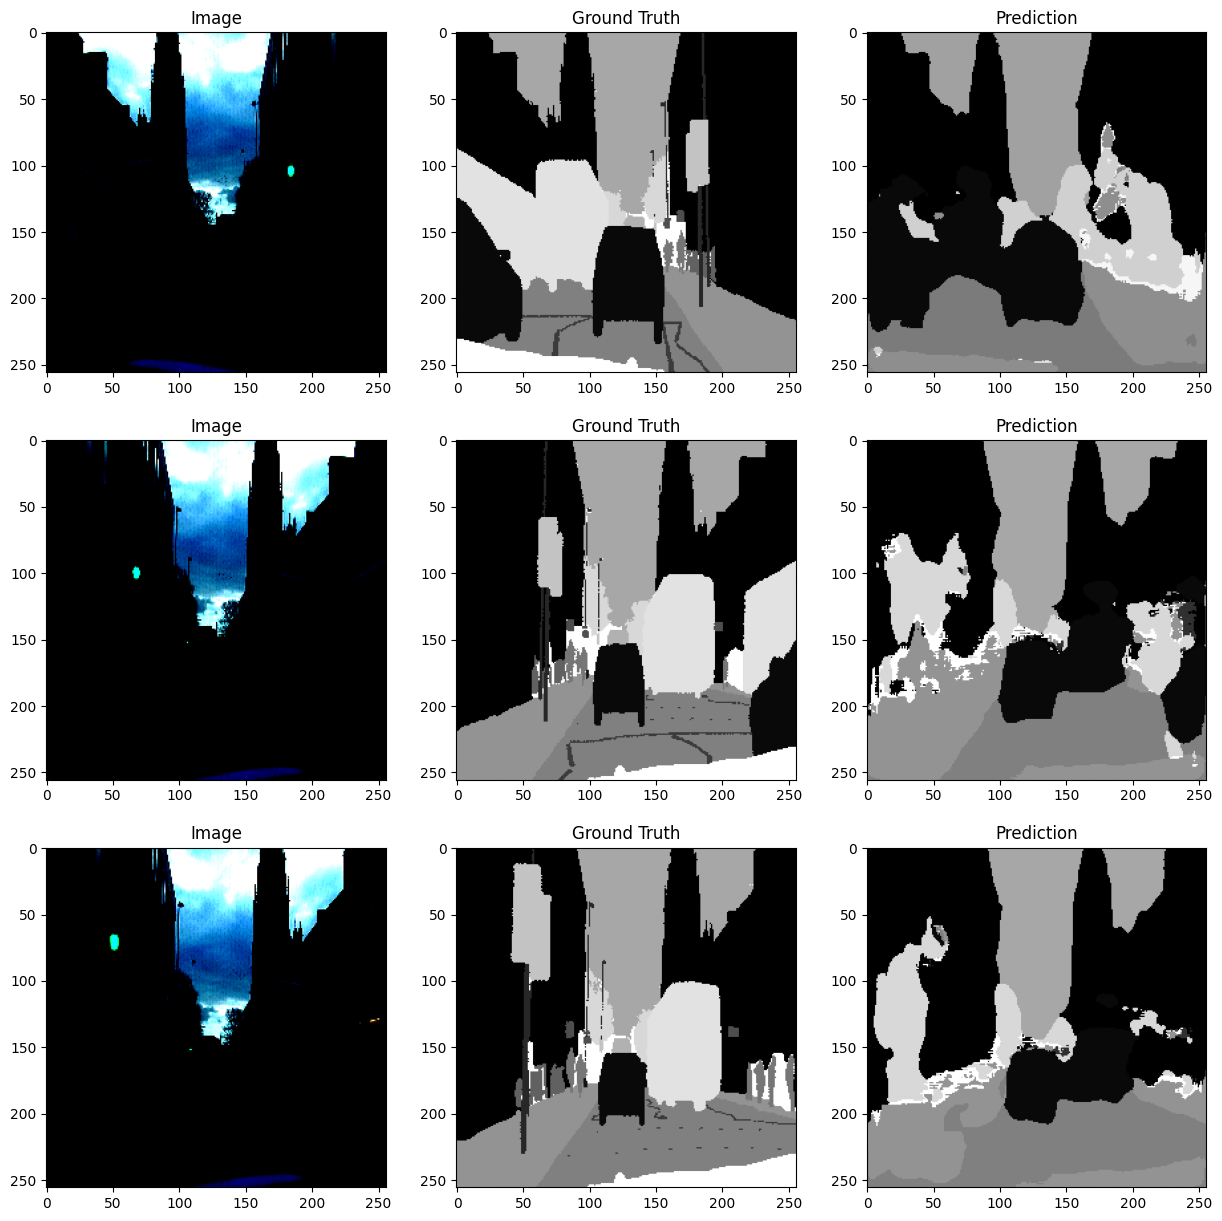

In [ ]:
# Тестирование модели
model.eval()
test_iou = 0
test_dice = 0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        test_iou += calculate_iou(outputs, masks)
        test_dice += calculate_dice(outputs, masks)

test_iou /= len(test_loader)
test_dice /= len(test_loader)

print(f'Test IoU: {test_iou:.3f}, Test Dice: {test_dice:.3f}')

# Визуализация примера
images, masks = next(iter(test_loader))
outputs = model(images.to(device))
preds = torch.argmax(outputs, dim=1).cpu()

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    axes[i, 0].imshow(images[i].permute(1, 2, 0))
    axes[i, 0].set_title('Image')
    axes[i, 1].imshow(masks[i], cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 2].imshow(preds[i], cmap='gray')
    axes[i, 2].set_title('Prediction')
plt.show()

In [ ]:
# Сохранение модели после обучения
torch.save(model.state_dict(), 'unet_segmentation_model.pth')

# Если вы хотите сохранить всю модель (включая архитектуру)
torch.save(model, 'unet_segmentation_full_model.pth')

Что было сделано:
1. Загружаем и предобрабатываем данные CamVid
2. Создаём модель U-Net для семантической сегментации
3. Обучаем модель с использованием функции потерь CrossEntropyLoss и оптимизатора Adam. Делаем небольшое количство эпох, так как недостаточно ресурсов
4. Выводит метрики качества (IoU, Dice) на тренировочном, валидационном и тестовом наборах
5. Визуализируем результаты работы модели
6. Сохраняем обученную модель для дальнейшего использования

### Оценка обучения

* С каждым последующим эпохой потери уменьшаются, достигнув минимального значения 0.721 на последней эпохе (Epoch 10). Это свидетельствует о том, что модель успешно обучается и минимизирует ошибку

* По мере прогресса обучения IoU увеличивается, достигнув значения 0.204 на последней эпохе. Однако это значение остается относительно низким, что может указывать на проблемы с точностью сегментации

* К концу обучения значение Dice выросло до 0.688, что является существенным улучшением. Однако, как и IoU, это значение остается недостаточно высоким для идеальной сегментации

* На валидационном наборе данные показывают аналогичную тенденцию: потери снижаются с каждой эпохой, начиная с 2.242 на первой эпохе и заканчивая 0.739 на последней

* На валидационном наборе IoU начинается с низкого значения (0.078) и постепенно растет до 0.212 на последней эпохе. Хотя IoU увеличился, его значение остается относительно низким, что может быть связано с сложностью задачи или недостаточной мощностью модели

* Значения Dice на валидационном наборе также демонстрируют положительную динамику, начиная с 0.236 и достигая 0.661 на последней эпохе. Подобно IoU, Dice показывает улучшение, но его окончательное значение остается ниже желаемого

### Тестовые резкльтаты

* Значение IoU (0.212) на тестовом наборе остается низким. Это указывает на то, что модель имеет трудности с точной локализацией объектов на изображениях. Возможно, модель недоучилась или требуются дополнительные аугментации/модификации архитектуры

* Значение Dice (0.666) выше, чем IoU, что является положительным моментом. Однако оно все еще недостаточно высокое для идеальной сегментации. Это может быть связано с тем, что Dice менее чувствителен к разницам в размерах областей, чем IoU

### Итог

* Модель U-Net с ResNet-34 показала удовлетворительные результаты на начальном этапе обучения, но ее точность (IoU и Dice) остается недостаточно высокой для сложной задачи семантической сегментации CamVid

* Модель успешно распознает некоторые крупные объекты, такие как дороги и здания

* Модель сталкивается с трудностями при сегментации более мелких объектов, таких как люди, автомобили и дорожные знаки. Предсказанные маски содержат "шум" и неточные границы, особенно в областях с низкой контрастностью или сложным фоном

* Присутствуют случаи "размытости" границ между классами.
Модель иногда путает соседние классы (например, часть дороги может быть неправильно отнесена к категории "зеленые насаждения")

### Что можно улучшить
* Оптимизировать гиперпараметры (например, сделать больше эпох обучения, так как их было немного)
* Улучшить архитектуру модели
* Усилить аугментации
* Рассмотреть использование дополнительных данных или техник классового баланса

#3. Пример аугментации

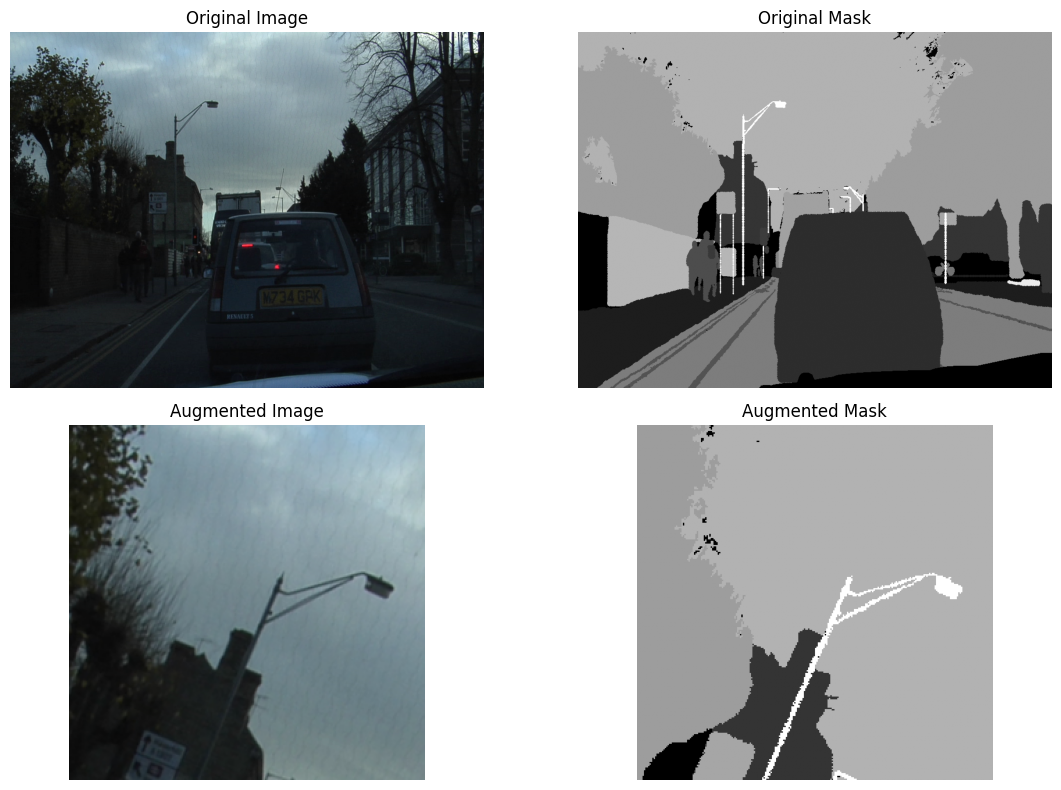

In [ ]:
# Загрузка изображения и маски
image = cv2.imread(f'{IMAGE_DIR}/0001TP_009420.png')
mask = cv2.imread(f'{MASK_DIR}/0001TP_009420_L.png', cv2.IMREAD_GRAYSCALE)

# Преобразование BGR -> RGB для корректного отображения
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Создание пайплайна аугментаций
transform = A.Compose([
    A.Rotate(limit=45, p=1),  # Поворот на случайный угол до 45 градусов
    A.RandomScale(scale_limit=0.2, p=1),  # Случайное масштабирование
    A.RandomCrop(width=256, height=256, p=1)  # Случайная обрезка до 256x256
])

# Применение аугментаций
augmented = transform(image=image, mask=mask)
augmented_image = augmented['image']
augmented_mask = augmented['mask']

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Исходное изображение
axes[0, 0].imshow(image)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Исходная маска
axes[0, 1].imshow(mask, cmap='gray')
axes[0, 1].set_title('Original Mask')
axes[0, 1].axis('off')

# Аугментированное изображение
axes[1, 0].imshow(augmented_image)
axes[1, 0].set_title('Augmented Image')
axes[1, 0].axis('off')

# Аугментированная маска
axes[1, 1].imshow(augmented_mask, cmap='gray')
axes[1, 1].set_title('Augmented Mask')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()